ZUM_NLP: PROJECT GUIDELINES <br>
The aim of the project is to create a model of sentiment analysis based on tweets about current events in the world. <br>
The full project consists of 4 stages, but depending on the expected final grade, it is enough to follow the stages indicated below: <br>
3 – stages 1B, 2 and 3 <br>
4 – stages 1B, 2-4 <br>
5 – stages 1A, 2-4 <br>
STAGE 1: DATA COLLECTION <br>

1A – data in Polish/English/Spanish/Swedish or Portuguese (so that I can understand it)
Data acquisition concerns the collection of tweets. Each person scraps tweets (about 20k) to create a dataset for further processing. Tweets should be about current events, such as the war, NATO etc.
1.	Adding class labels: Collected data is not tagged as positive/negative/neutral.<br>
a.	Select the number of target classes (2 or 3 if we include neutral).<br>
b.	Clean data and remove stopwords<br>
c.	Create word embeddings for vectorized representation of words simillar in meaning // OR we use pretrained model for language of choice <br>
d.	Use K-MEANS to create clusters and use k=2 or k=3 depending on the numer of target classes <br>
e.	Based on clusters tag data and manually fix clusters if necessary <br>
It is a good idea to limit the number of words as much as possible and possibly manually tag some of them too.<br>
2.	Data cleaning: normalisation, special characters removal, punctuation, URL, emails, duplicates, lowercase text and choose type of tokenizer. NOTICE: this stage is necessary BEFORE the creation of word embeddings.<br>
1B – ready data<br>
Use ready dataset (from Kaggle etc.)<br>
ETAP 2: CLASSIC ML<br>
Choose 3 models to fit data and present the results with confusion matric and roc curve. Just as in class. <br>
ETAP 3: NEURAL MODEL<br>
Choose type of neural network to train, and through validation decide on the best set of parameters. It is not enough to just build a model and get results. Fine-tuning is necessary too. <br>
In a loop we save the best model according to cost of validation. <br>
ETAP 4: LANGUAGE MODEL <br>
The last stage is to use selected language model, e.g. BERT, to create a sentiment analysis classifier. <br>

DEADLINE: check assigments in Teams <br>
SUBMISSION: GitHub repository – if its private, make sure to share with dwnuk@pjwstk.edu.pl. Then add url to repo in Teams assigment.
NOTICE! If you aim for 4 or 5, the project can be done in groups of up to 3 ppl, but with the requirement of using more advanced models (e.g., usage of two neural networks for comparison) and more than 1 language model. <br>
BEFORE SUBMISSION MAKE SURE THAT THE REPOSITORY CONTAINS: <br>
- scripts/python files .py, <br>
- README.md file with z project description and instructions how to use it, <br>
- saved models (as long as possible due to storage limits) <br>
- data used in the project in csv format or compressed <br>
- you can briefly describe achieved results in README file along with project overview, without going into too much detail.<br>

<br><br><br>



In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# !pip install tweepy --upgrade
# !pip install matplotlib
# !pip install pandas
# !pip install wordcloud
!pip install clean-text
!pip install spacy --upgrade
!python -m spacy download pl_core_news_lg
!python -m spacy download en_core_web_md
!pip install transformers==4.26.1
!pip install -U datasets
!pip install plot_keras_history -q
!pip install unidecode -q
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=474a0b7bb783d1b4c0b133d16ee408602f050b1261f6fb97dbd15c846d3f4771
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.6 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2
2023-05-24 13:36:44.402162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tensor

In [ ]:
from cleantext import clean
from datasets import Dataset, load_metric

from datetime import datetime, timedelta
from gensim.models import Word2Vec
from keras.models import Sequential
from gensim.models.phrases import Phrases, Phraser
from keras import backend as K
from keras import layers, regularizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from IPython.display import display
from plot_keras_history import show_history, plot_history
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from tensorflow.keras.optimizers import RMSprop, Adam
from time import time
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertModel, BertTokenizerFast, pipeline, TrainingArguments, Trainer, RobertaForSequenceClassification
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS
import emoji
import keras
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import re
import spacy
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import transformers
import tweepy



tqdm.pandas()

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
# wandb.init(project="", entity="")

# schowane

Pobieranie tweetów:<br>
  1) W języku angielskim --> ok 200 tyś.<br>
  2) W języku polskim --> ok 200 tyś.<br>

In [ ]:
def create_word_cloud(lista):
  comment_words = ''
  stopwords = set(STOPWORDS)
  
  for item in lista:
      
      tokens = item["cleaned_tweet"].split()
      tokens = [token.lower() for token in tokens]
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
  
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()

def get_old_data(last_days_num):
       now = datetime.now()
       then = now - timedelta(days=last_days_num)
       month = str(then.month).zfill(2)
       day = str(then.day).zfill(2)
       start_date = f"{then.year}-{month}-{day}T00:00:00Z"
       return start_date

class UserStats(object):
    def __init__(self, user):
        self.client = client
        self.username = user
        user = self.client.get_user(username=user, user_fields=["created_at", "public_metrics", "verified"])
        self.id = user.data.id
        self.created = user.data.created_at
        self.followers_number = user.data.public_metrics["followers_count"]
        self.followed_number = user.data.public_metrics["following_count"]
        self.tweet_number = user.data.public_metrics["tweet_count"]
        self.if_verified = user.data.verified

    def get_tweets(self, previous_days=30):
        self.previous_days = previous_days
        old_data = get_old_data(previous_days)
        query = f"from:{self.username}"
        self.last_tweets = self.client.search_all_tweets(query, start_time=old_data, max_results=300, tweet_fields=["public_metrics"])
        self.processed_tweets = [clean_tweet(tweet.text) for tweet in self.last_tweets.data]

    def calculate_popularity(self):
        self.popularity_score = sum([tt.public_metrics["retweet_count"] for tt in self.last_tweets.data]) + \
                                sum([tt.public_metrics["like_count"] for tt in self.last_tweets.data])
        self.reach_score = self.followers_number - self.followed_number

    def get_followers(self, max_results=100):
        followers = self.client.get_users_followers(self.id, max_results=max_results)
        return [follower.username for follower in followers.data]

    def print_basic_stats(self):
        print(f"Popularity score: {self.popularity_score}")
        print(f"Reach score: {self.reach_score}")



# Pobieranie tweetów

In [ ]:
academic_bearer = "AAAAAAAAAAAAAAAAAAAAADIEawEAAAAAxzzD4cQ2g8FGK2%2BkKz2%2FJvTnoMA%3D09uegYs5HrQvrsFkAEl3WwxhspBYFBIH3Vnykec79asqiUsSoA"
import tweepy
client = tweepy.Client(academic_bearer)
api = tweepy.API(academic_bearer)

In [ ]:
#Pobieranie tweetów po keyword
def get_tweets_keyword(language, keyword):
  tweets = []
  query =  'lang:' + language + ' ' + keyword
  tweet_fields = ['created_at']
  max_result = 500
  number_of_wanted_tweets = 60000
  iterations = (number_of_wanted_tweets / max_result)

  response = client.search_all_tweets(query=query, max_results=max_result, media_fields=None)
  next_token = response.meta['next_token']
  for i in range(int(iterations)):
    time.sleep(1)
    response = client.search_all_tweets(query=query, max_results=max_result, media_fields=None, next_token = next_token)
    tweets.extend(response.data)
    if(response.meta.get('next_token') == None):
      return tweets
    next_token = response.meta['next_token']

      
  return tweets

tweets_en = get_tweets_keyword('en', 'eurovision')

tweets_pl = get_tweets_keyword('pl', 'pis')


Zapisanie danych do csv

In [ ]:
pd.DataFrame(tweets_en).to_csv('eurovision.csv', index=False)
pd.DataFrame(tweets_pl).to_csv('pis_raw.csv', index=False)

#Funkcje pomocnicze


In [ ]:
def create_tfidf_dictionary(x, transformed_file, features):
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.title.split()))



In [ ]:
def replace_sentiment_words(word, sentiment_dict):

    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [ ]:
def predict(model, texts_to_test, tokenizer, sequence_length=200):

    sequences = tokenizer.texts_to_sequences(texts_to_test)
    padded = pad_sequences(sequences, maxlen=200, dtype='int32', value=0)
    prediction = model.predict(padded,batch_size=1,verbose = 2)[0]

    print(prediction)

    pred_labels = []
    
    if np.argmax(prediction) == 2:
        pred_labels.append(1)
    elif np.argmax(prediction) == 1:
        pred_labels.append(0) 
    else:
        pred_labels.append(-1)

    for i in range(1):
        print(texts_to_test)
        if pred_labels[i] == 1:
            s = 'Positive'
        elif(pred_labels[i] == 0):
            s = 'Neutral'
        else:
            s = 'Negative'
        print("Predicted sentiment : ",s)

# Dobre 

Wczytanie danych z csv i wstępne czysczenie

In [ ]:

RETWEETED_REGEX = r"^RT @([^ ]+):"
USER_REGEX = r"@([^ ]+)"
URL_REGEX = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
CHARACTER_REGEX = r"[^a-zA-Z\s']"

def clean_tweet(tweets):
    cleaned_tweets = []
    for t in tweets:
      t = re.sub(RETWEETED_REGEX, "", t)
      t = re.sub(USER_REGEX, "", t)
      t = re.sub(URL_REGEX, "", t)
      # t = re.sub(CHARACTER_REGEX, "", t)
      tw = emoji.replace_emoji(t, replace='')
      cleaned_tweets.append(tw.strip().replace('\n', ' '))
      
    return cleaned_tweets

tweets_en_clean = clean_tweet(pd.read_csv('eurovision.csv', encoding="utf-8")['text'])
tweets_pl_clean =  clean_tweet(pd.read_csv('pis_raw.csv', encoding="utf-8")['text'])

FileNotFoundError: ignored

Zapisanie danych do df

In [ ]:
tweets_en_df = pd.DataFrame(tweets_en_clean, columns=['text'])
tweets_pl_df = pd.DataFrame(tweets_pl_clean, columns=['text'])

# Usunięcie duplikatów

In [ ]:
tweets_en_df.drop_duplicates(inplace=True)
tweets_pl_df.drop_duplicates(inplace=True)

# Modele

Wczytanie modeli

In [ ]:
nlp_en = spacy.load("en_core_web_md", disable=['ner', 'parser'])
nlp_en.add_pipe('sentencizer')

nlp_pl = spacy.load("pl_core_news_lg", disable=['ner', 'parser'])
nlp_pl.add_pipe('sentencizer')

Usunięcie stop wordów

In [ ]:
def remove_stopwords_en(text):
  return ' '.join(filter(lambda x: x not in nlp_en.Defaults.stop_words, text.split()))

def remove_stopwords_pl(text):
  return ' '.join(filter(lambda x: x not in nlp_pl.Defaults.stop_words, text.split()))

tweets_en_df['text'] = tweets_en_df['text'].apply(remove_stopwords_en)
tweets_pl_df['text'] = tweets_pl_df['text'].apply(remove_stopwords_pl)

Lematyzacja

In [ ]:
def lemmatize_en(text):
  return ' '.join([x.lemma_ for x in nlp_en(text)])

def lemmatize_pl(text):
  return ' '.join([x.lemma_ for x in nlp_pl(text)])

tweets_en_df['text_lemmatized'] = tweets_en_df['text'].progress_apply(lemmatize_en)
tweets_pl_df['text_lemmatized'] = tweets_pl_df['text'].progress_apply(lemmatize_pl)

100%|██████████| 19560/19560 [02:56<00:00, 110.93it/s]


In [ ]:
tweets_pl_df

,text,text_lemmatized
0,Od czasu wpuszczenia ukraińskiego zboża polski...,od czas wpuszczeć ukraiński zboże polski rynek...
1,Za nikt tyle odbierze ukradnie PIS.. wolę mieć...,za nikt tyle odebrać ukradnie PIS . . woleć mi...
2,Minister Podpisała dokument przyspieszyć trans...,minister podpisać dokument przyspieszyć transf...
3,Pozytywny przekaz majstrowania komisarzach. Pi...,pozytywny przekaz majstrować komisarza . PiS w...
5,Platforma media atakują kłamstwami manipulacja...,platforma media atakować kłamstwo manipulacj d...
...,...,...
59968,Mów siebie. Za długo obserwuje scenę polityczn...,mów siebie . za długo obserwować scena polityc...
59969,"Dla kogo eldorado, emerytów rządzących, dzięki...","dla kto eldorado , emeryt rządzący , dzięki pr..."
59972,Przestań dziewczę bełkotać! Bzdury gaworzysz !...,Przestań dziewczę bełkotać ! Bzdura gaworzyć !...
59974,Czyli woli Pan PiS likwidację państwa?,czyli woleć pan PiS likwidacja państwo ?


Chmury słów

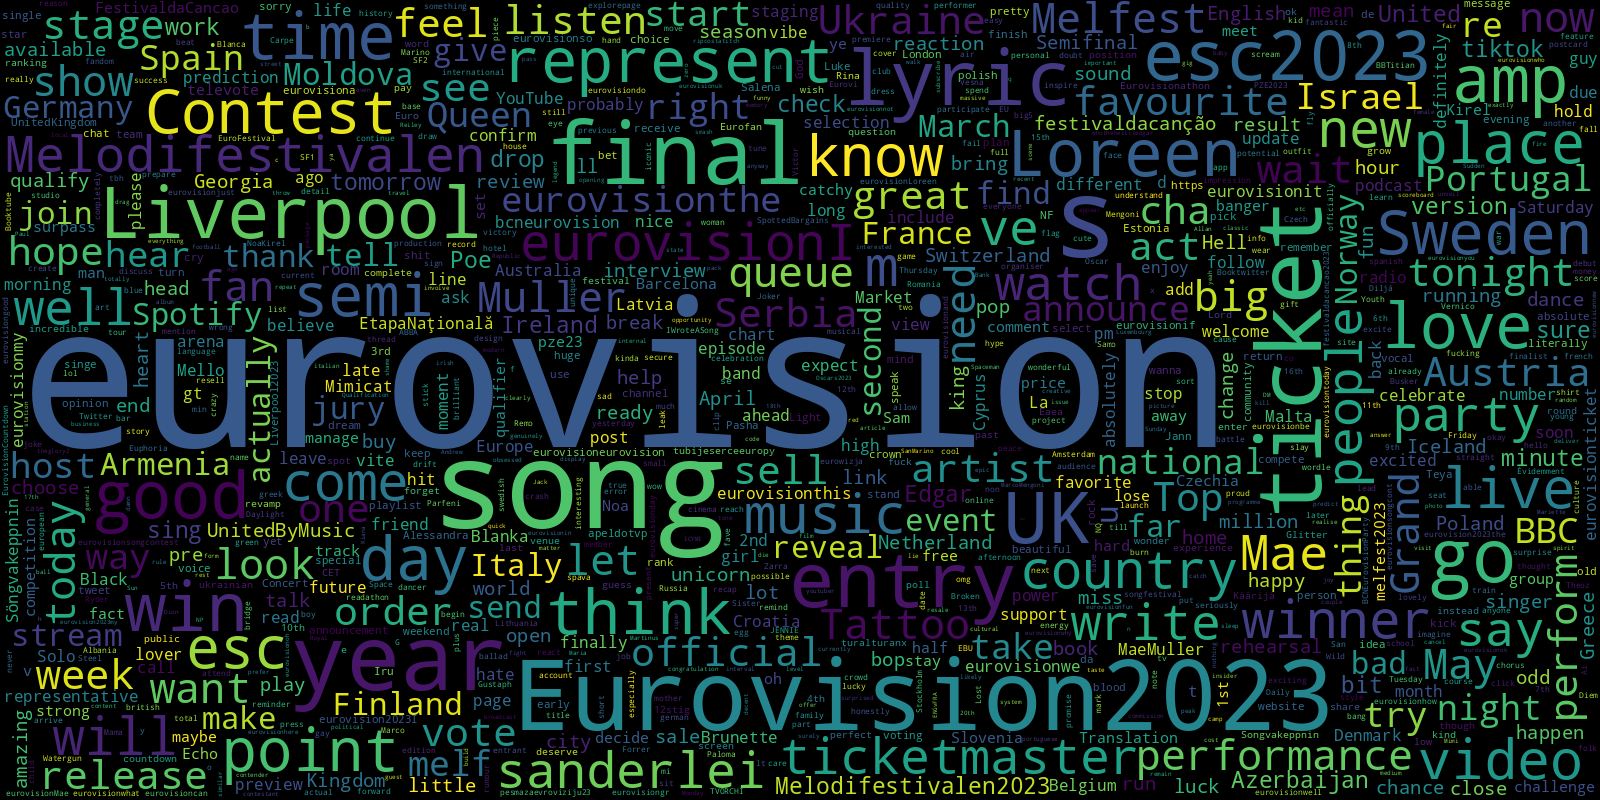

In [ ]:
text = ''.join(tweets_en_df['text_lemmatized'])
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text)
wc.to_image()

Klasyfikacja

In [ ]:
# Define pipeline
classifier_en = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis") 
classifier_pl = pipeline(model="bardsai/twitter-sentiment-pl-base") 

In [ ]:
tweets_en = []
for tweet in tweets_en_df['text_lemmatized'].to_list():
   try:
     sentiment = classifier_en(tweet)
     tweets_en.append({'tweet': tweet, 'sentiment': sentiment[0]['label']})
 
   except:
     pass

In [ ]:
tweets_pl = []
# for tweet in tmp['text']:
for tweet in tweets_pl_df['text_lemmatized'].to_list():
   try:
     sentiment = classifier_pl(tweet)
     tweets_pl.append({'tweet': tweet, 'sentiment': sentiment[0]['label']})
 
   except:
     pass

In [ ]:
tweets_en

In [ ]:
pd.DataFrame(tweets_en).to_csv('tweets_with_labels_en.csv', index=False)

In [ ]:
pd.DataFrame(tweets_pl).to_csv('tweets_with_labels_pl.csv', index=False)

#Wczytanie i obróbka przygotowanych danych z pliku CSV

In [ ]:
tweets_en = pd.read_csv('tweets_with_labels_en.csv')
tweets_pl = pd.read_csv('tweets_with_labels_pl.csv')

Otagowanie dataframów

In [ ]:
conditions_en = [
    (tweets_en['sentiment'] == 'POS'),
    (tweets_en['sentiment'] == 'NEU'),
    (tweets_en['sentiment'] == 'NEG')
]
values = [1,0,-1]

tweets_en['target'] = np.select(conditions_en, values) 

conditions_pl = [
    (tweets_pl['sentiment'] == 'positive'),
    (tweets_pl['sentiment'] == 'neutral'),
    (tweets_pl['sentiment'] == 'negative')
]

tweets_pl['target'] = np.select(conditions_pl, values) 

In [ ]:
data_pl = tweets_pl.dropna().drop_duplicates().reset_index(drop=True)
data_en = tweets_en.dropna().drop_duplicates().reset_index(drop=True)

In [ ]:
def clean_data(text):

  text = unidecode(text)
  text = str(text)
  text = text.lower()

  text = re.sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
  text = re.sub(r"\+", " plus ", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ! ", text)
  text = re.sub(r"\?", " ? ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r":", " : ", text)
  text = re.sub(r"\s{2,}", " ", text)

  return text

In [ ]:
data_pl.tweet = data_pl.tweet.apply(lambda x: clean_data(x))
data_en.tweet = data_en.tweet.apply(lambda x: clean_data(x))

#KMeans - Język Polski

In [ ]:
file_cleaned_pl = data_pl.rename(columns={'tweet':'title', 'target':'rate'})

In [ ]:
file_cleaned_pl.rate.value_counts()/len(file_cleaned_pl)
file_cleaned_pl[file_cleaned_pl.rate==0]
file_cleaned_pl = file_cleaned_pl[file_cleaned_pl.rate!=0]
file_cleaned_pl.rate.value_counts()/len(file_cleaned_pl)


-1    0.897321
 1    0.102679
Name: rate, dtype: float64

In [ ]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = clean_data(text)
    text = text.split()

    return text  


In [ ]:
file_cleaned_pl.title = file_cleaned_pl.title.apply(lambda x: text_to_word_list(x))
file_model_pl = file_cleaned_pl.copy()
file_model_pl = file_model_pl[file_model_pl.title.str.len()>1]


In [ ]:
sent = [row for row in file_model_pl.title]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences_pl = bigram[sent]
sentences_pl[1]

['na',
 'czekac',
 'i',
 '100',
 'i',
 'wielki',
 'nadzieja',
 'wy',
 'rowniez',
 'wyjdzmy',
 'pokazmy',
 'sprzeciw',
 '!_!',
 '!',
 'w_czerwiec',
 'wielki_marsz']

In [ ]:
w2v_model_pl = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-4, 
                     alpha=0.15, 
                     min_alpha=0.006, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

w2v_model_pl.build_vocab(sentences_pl, progress_per=50000)

# w2v_model_pl = Word2Vec(min_count=3,
#                      window=4,
#                      vector_size=300,
#                      sample=1e-5, 
#                      alpha=0.14, 
#                      min_alpha=0.007, 
#                      negative=20,
#                      workers=multiprocessing.cpu_count()-1)

# w2v_model_pl.build_vocab(sentences_pl, progress_per=50000)

In [ ]:
w2v_model_pl.train(sentences_pl,
                total_examples=w2v_model_pl.corpus_count,
                epochs=30,
                report_delay=1)

w2v_model_pl.init_sims(replace=True)

<ipython-input-18-82867c9eb7cc>:6: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model_pl.init_sims(replace=True)


In [ ]:
w2v_model_pl.save("word2vec_pl.model")

In [ ]:
file_export_pl = file_model_pl.copy()
file_export_pl['old_title'] = file_export_pl.title
file_export_pl.old_title = file_export_pl.old_title.str.join(' ')
file_export_pl.title = file_export_pl.title.apply(lambda x: ' '.join(bigram[x]))
file_export_pl.rate = file_export_pl.rate.astype('int8')

In [ ]:
file_export_pl[['title', 'rate']].to_csv('cleaned_dataset_pl.csv', index=False)

In [ ]:
word_vectors_pl = Word2Vec.load("word2vec_pl.model").wv

model_pl = KMeans(n_clusters=2,
               max_iter=1000,
               random_state=True,
               n_init=50)
model_pl.fit(X=word_vectors_pl.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=True)

In [ ]:
word_vectors_pl.similar_by_vector(model_pl.cluster_centers_[1], topn=10, restrict_vocab=None)

[('pretensja_demokratyczny', 0.9844341278076172),
 ('emerytom_dobrze', 0.9790809750556946),
 ('zdolny_kazdy', 0.9727032780647278),
 ('totalna_porazka', 0.9711011052131653),
 ('stadnina_kon', 0.9671549797058105),
 ('taaaa', 0.964419960975647),
 ('zdjecie_jpii', 0.9640563726425171),
 ('posmiewisek', 0.9582293033599854),
 ('nie_draznic', 0.9559149742126465),
 ('swiatopogladowo', 0.9554888010025024)]

In [ ]:
positive_cluster_index = 1
positive_cluster_center_pl = model_pl.cluster_centers_[positive_cluster_index]
negative_cluster_center_pl = model_pl.cluster_centers_[1-positive_cluster_index]

In [ ]:
words_pl = pd.DataFrame(word_vectors_pl.index_to_key)
words_pl.columns = ['words']
words_pl['vectors'] = words_pl.words.apply(lambda x: word_vectors_pl[f'{x}'])
words_pl['cluster'] = words_pl.vectors.apply(lambda x: model_pl.predict([np.array(x)]))
words_pl.cluster = words_pl.cluster.apply(lambda x: x[0])
words_pl['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words_pl.cluster]
words_pl['closeness_score'] = words_pl.apply(lambda x: 1/(model_pl.transform([x.vectors]).min()), axis=1)
words_pl['sentiment_coeff'] = words_pl.closeness_score * words_pl.cluster_value

In [ ]:
words_pl[words_pl.cluster != 1].sample(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
5523,symbol_wiarygodnosc,"[0.049142446, 0.003311821, 0.14977337, -0.0047...",0,-1,1.251787,-1.251787
4171,10_zloty,"[-0.038700547, -0.026931446, 0.19706433, 0.095...",0,-1,1.365176,-1.365176
2350,kolano,"[0.024854949, 0.02925651, 0.13509017, 0.082246...",0,-1,1.605629,-1.605629
6611,okrasc_polak,"[-0.008891415, 0.012760632, 0.21102425, 0.0610...",0,-1,1.800091,-1.800091
4240,pogodzic,"[0.055127956, 0.060874447, 0.07073823, 0.02950...",0,-1,1.600153,-1.600153
7018,kurde,"[-0.029738313, -0.007393459, 0.1166453, 0.0552...",0,-1,1.640191,-1.640191
4489,odsuc,"[0.120333105, -0.00849076, 0.14188728, 0.06812...",0,-1,1.783054,-1.783054
2127,nastapic,"[0.060201723, -0.02969903, 0.17157413, 0.07898...",0,-1,1.634349,-1.634349
2831,przeprosic,"[-0.027223447, 0.03506893, 0.08968382, -0.0110...",0,-1,1.380790,-1.380790
5625,siegac_opozycja,"[0.02190494, 0.030864256, 0.03227992, -0.06601...",0,-1,1.198334,-1.198334


In [ ]:
words_pl[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary_pl.csv', index=False)

In [ ]:
final_file_pl = pd.read_csv('cleaned_dataset_pl.csv')
sentiment_map_pl = pd.read_csv('sentiment_dictionary_pl.csv')
sentiment_dict_pl = dict(zip(sentiment_map_pl.words.values, sentiment_map_pl.sentiment_coeff.values))

In [ ]:
file_weighting_pl = final_file_pl.copy()
tfidf_pl = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf_pl.fit(file_weighting_pl.title)
features_pl = pd.Series(tfidf_pl.get_feature_names_out())
transformed_pl = tfidf_pl.transform(file_weighting_pl.title)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
replaced_tfidf_scores_pl = file_weighting_pl.apply(lambda x: replace_tfidf_words(x, transformed_pl, features_pl), axis=1)

In [ ]:
replaced_closeness_scores_pl = file_weighting_pl.title.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict_pl), x.split())))

In [ ]:
replacement_df_pl = pd.DataFrame(data=[replaced_closeness_scores_pl, replaced_tfidf_scores_pl, file_weighting_pl.title, file_weighting_pl.rate]).T
replacement_df_pl.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
replacement_df_pl['sentiment_rate'] = replacement_df_pl.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df_pl['prediction'] = (replacement_df_pl.sentiment_rate>0).astype('int8')
replacement_df_pl['sentiment'] = [1 if i==1 else 0 for i in replacement_df_pl.sentiment]

In [ ]:
replacement_df_pl[replacement_df_pl['prediction'] == 0].sample(10)

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
5653,"[-1.281597349851216, 0, -1.341478284887109, -1...","[3.703007568253312, 9.331827004436057, 7.86548...",polska spelniec standard pis,1,-16.568243,0
11149,"[-1.190761416525378, -1.5531687786636117, 1.40...","[1.0674636747043904, 6.669239177410605, 5.3552...",pis bron pisowski patola klamstwa szczujnia,0,-32.745753,0
88,"[1.302263793229227, 1.4926201319485846, -1.391...","[3.1657091151743, 5.495965359973476, 12.121982...",to dzieki rolnik pis wiekszosc rolnik glosowac...,0,-23.716239,0
5472,"[-1.3021042847710074, 1.3486629614678698, -1.2...","[3.593106478418576, 5.312445480687412, 9.04414...",nie musiec biorac_uwaga napiecie wewnatrz konf...,0,-10.367581,0
11320,"[-1.2613279327825235, 0, 1.6354986972715622, 0...","[3.979968870959991, 9.331827004436057, 7.33939...",i niestety_racja poprzez wyprowadzec znaczny k...,0,-3.267481,0
4532,"[-1.4873652076062354, 1.3915074301266137, 0, -...","[5.112319299259951, 4.229930119061477, 9.73729...",z ten obnizka_podatek pis zgodzic nie liczyc s...,0,-106.720257,0
576,"[0, -1.190761416525378, -1.7412977875225404, -...","[9.737292112544221, 1.0674636747043904, 8.3509...",funkcjonariuszka pis beznadziejny kazdy_cal,0,-28.899022,0
9280,"[-1.7322532087331568, 0, 0, -1.598329389595168...","[9.044144931984277, 9.737292112544221, 9.73729...",towarzyszka spesc pisobolszewik klakier powied...,0,-45.037006,0
1422,"[1.3716700487397933, 0, -1.556501943570607, -1...","[4.456629681234906, 9.331827004436057, 7.79138...",jak zygac nas pis ? kasiorka worek idiota ?,0,-57.705246,0
4840,"[-1.2084817406064248, -1.257356146528765, -1.5...","[5.248655742812082, 9.667738265015076, 5.91957...",inflacja ! drozyzna ! bieda ! a pisowiec rozda...,0,-73.648323,0


In [ ]:
replacement_df_pl.groupby(['prediction']).count()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate
prediction,,,,,
0,3456,3456,3456,3456,3456
1,9005,9005,9005,9005,9005


In [ ]:
predicted_classes_pl = replacement_df_pl.prediction
y_test_pl = replacement_df_pl.sentiment

conf_matrix_pl = pd.DataFrame(confusion_matrix(replacement_df_pl.sentiment, replacement_df_pl.prediction))
print('Confusion Matrix')
display(conf_matrix_pl)

test_scores_pl = accuracy_score(y_test_pl,predicted_classes_pl), precision_score(y_test_pl, predicted_classes_pl), recall_score(y_test_pl, predicted_classes_pl), f1_score(y_test_pl, predicted_classes_pl)

print('\n \n Scores')
scores_pl = pd.DataFrame(data=[test_scores_pl])
scores_pl.columns = ['accuracy', 'precision', 'recall', 'f1']
scores_pl = scores_pl.T
scores_pl.columns = ['scores']
display(scores_pl)

Confusion Matrix


,0,1
0,3034,8150
1,422,855



 
 Scores


,scores
accuracy,0.312094
precision,0.094947
recall,0.669538
f1,0.166310


#KMeans - Język Angielski

In [ ]:
file_cleaned_en = data_en.rename(columns={'tweet':'title', 'target':'rate'})

In [ ]:
file_cleaned_en.rate.value_counts()/len(file_cleaned_en)
file_cleaned_en[file_cleaned_en.rate==0]
file_cleaned_en = file_cleaned_en[file_cleaned_en.rate!=0]
file_cleaned_en.rate.value_counts()/len(file_cleaned_en)

 1    0.744237
-1    0.255763
Name: rate, dtype: float64

In [ ]:
file_cleaned_en.title = file_cleaned_en.title.apply(lambda x: text_to_word_list(x))
file_model_en = file_cleaned_en.copy()
file_model_en = file_model_en[file_model_en.title.str.len()>1]

In [ ]:
sent = [row for row in file_model_en.title]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences_en = bigram[sent]
sentences_en[1]

['junior',
 'eurovision',
 '2023',
 'hold_nice',
 'november_26',
 '!',
 'junioreurovusion_jesc',
 'jesc2023',
 'eurovision',
 'eurovisio']

In [ ]:
w2v_model_en = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-4, 
                     alpha=0.12, 
                     min_alpha=0.007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

w2v_model_en.build_vocab(sentences_en, progress_per=50000)

In [ ]:
w2v_model_en.train(sentences_en,
                total_examples=w2v_model_en.corpus_count,
                epochs=25,
                report_delay=1)

w2v_model_en.init_sims(replace=True)

<ipython-input-459-ef18114cefca>:6: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model_en.init_sims(replace=True)


In [ ]:
w2v_model_en.save("word2vec_en.model")

In [ ]:
file_export_en = file_model_en.copy()
file_export_en['old_title'] = file_export_en.title
file_export_en.old_title = file_export_en.old_title.str.join(' ')
file_export_en.title = file_export_en.title.apply(lambda x: ' '.join(bigram[x]))
file_export_en.rate = file_export_en.rate.astype('int8')

In [ ]:
file_export_en[['title', 'rate']].to_csv('cleaned_dataset_en.csv', index=False)

In [ ]:
word_vectors_en = Word2Vec.load("word2vec_en.model").wv

In [ ]:
model_en = KMeans(n_clusters=2,
               max_iter=1000,
               random_state=True,
               n_init=50)
model_en.fit(X=word_vectors_en.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=True)

In [ ]:
word_vectors_en.similar_by_vector(model_en.cluster_centers_[1], topn=10, restrict_vocab=None)

[('l_lm', 0.8394796252250671),
 ('a_royal', 0.6671769618988037),
 ('mummi_lu', 0.6069812774658203),
 ('nemot', 0.5736380219459534),
 ('kramer_/', 0.5563502907752991),
 ('unitedbymusic_myeurofreak', 0.5561437606811523),
 ('fun_after', 0.5446232557296753),
 ('leejaewook', 0.5340744853019714),
 ('france_lazarra', 0.5288264751434326),
 ('leejaewook_galapremierewgua', 0.518953800201416)]

In [ ]:
positive_cluster_index = 1
positive_cluster_center_en = model_en.cluster_centers_[positive_cluster_index]
negative_cluster_center_en = model_en.cluster_centers_[1-positive_cluster_index]

In [ ]:
words_en = pd.DataFrame(word_vectors_en.index_to_key)
words_en.columns = ['words']
words_en['vectors'] = words_en.words.apply(lambda x: word_vectors_en[f'{x}'])
words_en['cluster'] = words_en.vectors.apply(lambda x: model_en.predict([np.array(x)]))
words_en.cluster = words_en.cluster.apply(lambda x: x[0])
words_en['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words_en.cluster]
words_en['closeness_score'] = words_en.apply(lambda x: 1/(model_en.transform([x.vectors]).min()), axis=1)
words_en['sentiment_coeff'] = words_en.closeness_score * words_en.cluster_value

In [ ]:
words_en[words_en.cluster != 1].sample(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
1622,podcast_app,"[-0.016586509, 0.0404935, 0.023777502, 0.04292...",0,-1,1.026814,-1.026814
591,million_view,"[0.03770035, -0.12916237, 0.0047037858, -0.059...",0,-1,1.067190,-1.067190
650,sale,"[-0.040351745, -0.08238686, -0.030970206, -0.0...",0,-1,1.037432,-1.037432
4469,family_show,"[0.06792471, -0.015969709, -0.02621744, -0.006...",0,-1,1.035988,-1.035988
2779,shirt,"[-0.083372265, -0.0101030385, 0.031909652, 0.0...",0,-1,1.053488,-1.053488
2326,want_miss,"[-0.08528803, 0.025007857, 0.086480565, 0.0166...",0,-1,1.054040,-1.054040
1910,superfan,"[-0.008167628, 0.025059884, -0.039289735, -0.0...",0,-1,1.098751,-1.098751
4422,roberts_weeema,"[-0.037216973, -0.013406323, 0.06514294, 0.027...",0,-1,1.159443,-1.159443
3478,excuse,"[0.019254517, 0.0012873608, -0.050885078, 0.02...",0,-1,1.036253,-1.036253
3919,dazzle,"[-0.008243985, 0.019201495, -0.011805144, 0.00...",0,-1,1.070845,-1.070845


In [ ]:
words_en[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary_en.csv', index=False)

In [ ]:
final_file_en = pd.read_csv('cleaned_dataset_en.csv')
sentiment_map_en = pd.read_csv('sentiment_dictionary_en.csv')
sentiment_dict_en = dict(zip(sentiment_map_en.words.values, sentiment_map_en.sentiment_coeff.values))

In [ ]:
file_weighting_en = final_file_en.copy()
tfidf_en = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf_en.fit(file_weighting_en.title)
features_en = pd.Series(tfidf_en.get_feature_names_out())
transformed_en = tfidf_en.transform(file_weighting_en.title)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
replaced_tfidf_scores_en = file_weighting_en.apply(lambda x: replace_tfidf_words(x, transformed_en, features_en), axis=1)

In [ ]:
replaced_closeness_scores_en = file_weighting_en.title.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict_en), x.split())))

In [ ]:
replacement_df_en = pd.DataFrame(data=[replaced_closeness_scores_en, replaced_tfidf_scores_en, file_weighting_en.title, file_weighting_en.rate]).T
replacement_df_en.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
replacement_df_en['sentiment_rate'] = replacement_df_en.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df_en['prediction'] = (replacement_df_en.sentiment_rate>0).astype('int8')
replacement_df_en['sentiment'] = [1 if i==1 else 0 for i in replacement_df_en.sentiment]

In [ ]:
replacement_df_en[replacement_df_en['prediction'] == 0].sample(10)

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
1227,"[-1.1348723882529017, -1.1735411829124218, -1....","[7.992514120918473, 8.44449924466153, 8.444499...",royal_albert dock_ready welcome_float earth eu...,1,-18.827663,0
10130,"[1.004222574843066, -1.0996732157131677, -1.04...","[3.41780314241509, 8.44449924466153, 6.7268477...",the tm website play some i hope ticket eurovis...,1,-22.890843,0
5235,"[0, -1.0176774251375529, -1.0245632876201547, ...","[9.291797105048733, 16.88899848932306, 5.87954...",inspired particular news story particular jour...,1,-14.696662,0
9650,"[-1.112030285405566, 0, 1.004320139729006, -0....","[8.310967852037008, 9.291797105048733, 1.05520...",ticketmaster_absolute piss_huge eurovision fan...,0,-99.505868,0
2609,"[1.004222574843066, 1.004320139729006, -0.9973...","[6.83560628483018, 1.0552000396947916, 5.09710...",the eurovision song_contest come big_screen ! ...,1,-3.214966,0
9148,"[1.0188744134220151, 1.004320139729006, -1.001...","[5.077203414675056, 2.110400079389583, 5.47775...",amazing eurovision grand_final ticket_sell 36_...,1,-24.240725,0
7262,"[0, 0, -1.1518339922620495, -1.114065620793644...","[9.291797105048733, 9.291797105048733, 7.90550...",5_discount code_bbvrxz shugatiti_valentine gif...,1,-73.030824,0
9698,"[-1.050864894622653, 1.004320139729006, -1.153...","[4.458164206268833, 1.0552000396947916, 9.0041...",ticketmaster eurovision literally_watch ticket...,0,-18.903512,0
5210,"[1.0111196476774256, 1.0104347107671257, 1.000...","[5.826061202249007, 2.07729269089759, 5.112294...",nice ! will check tomorrow_sundayfunday bbtiti...,1,-9.176145,0
4268,"[1.0000592032323703, -1.0940997842029485, 0.99...","[5.203023587876089, 9.004115032596953, 6.80689...",one item update eurovision focus announcement ...,1,-4.943988,0


In [ ]:
replacement_df_en.groupby(['prediction']).count()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate
prediction,,,,,
0,2162,2162,2162,2162,2162
1,9810,9810,9810,9810,9810


In [ ]:
predicted_classes_en = replacement_df_en.prediction
y_test_en = replacement_df_en.sentiment

conf_matrix_en = pd.DataFrame(confusion_matrix(replacement_df_en.sentiment, replacement_df_en.prediction))
print('Confusion Matrix')
display(conf_matrix_en)

test_scores_en = accuracy_score(y_test_en,predicted_classes_en), precision_score(y_test_en, predicted_classes_en), recall_score(y_test_en, predicted_classes_en), f1_score(y_test_en, predicted_classes_en)

print('\n \n Scores')
scores_en = pd.DataFrame(data=[test_scores_en])
scores_en.columns = ['accuracy', 'precision', 'recall', 'f1']
scores_en = scores_en.T
scores_en.columns = ['scores']
display(scores_en)

Confusion Matrix


,0,1
0,735,2327
1,1427,7483



 
 Scores


,scores
accuracy,0.686435
precision,0.762793
recall,0.839843
f1,0.799466


# Modele klasyczne




Przygotowanie danych do klasyfikacji

In [ ]:
X_train_pl, X_test_pl, y_train_pl, y_test_pl = train_test_split(data_pl.tweet, data_pl.target, test_size=0.1, stratify=data_pl.target, random_state=42)
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(data_en.tweet, data_en.target, test_size=0.1, stratify=data_en.target, random_state=42)

In [ ]:
vactorizer_pl = TfidfVectorizer(max_features=500000, ngram_range=(1,2))
vactorizer_pl.fit(X_train_pl)

vactorizer_en = TfidfVectorizer(max_features=500000, ngram_range=(1,2))
vactorizer_en.fit(X_train_en)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
X_train_pl = vactorizer_pl.transform(X_train_pl)
X_test_pl = vactorizer_pl.transform(X_test_pl)

X_train_en = vactorizer_en.transform(X_train_en)
X_test_en = vactorizer_en.transform(X_test_en)

Pomocnicze

In [ ]:
from sklearn.metrics import roc_curve, auc
def create_roc_curve(y_pred, y_test):
  fpr, tpr, _ = roc_curve(y_test,  y_pred, pos_label=1)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  fpr, tpr, _ = roc_curve(y_test,  y_pred, pos_label=0)
  plt.plot(fpr,tpr)
  plt.ylabel('True Neutral Rate')
  plt.xlabel('False Neutral Rate')
  plt.show()

  fpr, tpr, _ = roc_curve(y_test,  y_pred, pos_label=-1)
  plt.plot(fpr,tpr)
  plt.ylabel('True Negative Rate')
  plt.xlabel('False Negative Rate')
  plt.show()

def predict_classic_model(model, vectorizer, text_to_test, language):
  text = clean_data(text_to_test)

  if language == 'pl':
    text = remove_stopwords_pl(text)
    text = lemmatize_pl(text)
  else: 
    text = remove_stopwords_en(text)
    text = lemmatize_en(text)

  prediction = model.predict(vectorizer.transform([text_to_test]))

  if prediction == 1:
    s = 'Positive'
  elif prediction == 0:
    s = 'Neutral'
  elif prediction == -1:
    s = 'Negative'

  print("Predicted sentiment: ", s)

Naive Bayes

In [ ]:
model_pl = BernoulliNB()
model_pl.fit(X_train_pl, y_train_pl)

model_en = BernoulliNB()
model_en.fit(X_train_en, y_train_en)

BernoulliNB()

In [ ]:
y_pred_pl = model_pl.predict(X_test_pl)
confusion_matrix(y_test_pl, y_pred_pl)

y_pred_en = model_en.predict(X_test_en)
confusion_matrix(y_test_en, y_pred_en)

array([[   4,  276,   26],
       [   1, 1435,   56],
       [   0,  533,  358]])

In [ ]:
print(classification_report(y_test_pl, y_pred_pl))

              precision    recall  f1-score   support

          -1       0.61      0.96      0.74      1119
           0       0.66      0.16      0.26       702
           1       0.00      0.00      0.00       128

    accuracy                           0.61      1949
   macro avg       0.42      0.38      0.34      1949
weighted avg       0.59      0.61      0.52      1949



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test_en, y_pred_en))

              precision    recall  f1-score   support

          -1       0.80      0.01      0.03       306
           0       0.64      0.96      0.77      1492
           1       0.81      0.40      0.54       891

    accuracy                           0.67      2689
   macro avg       0.75      0.46      0.44      2689
weighted avg       0.72      0.67      0.61      2689



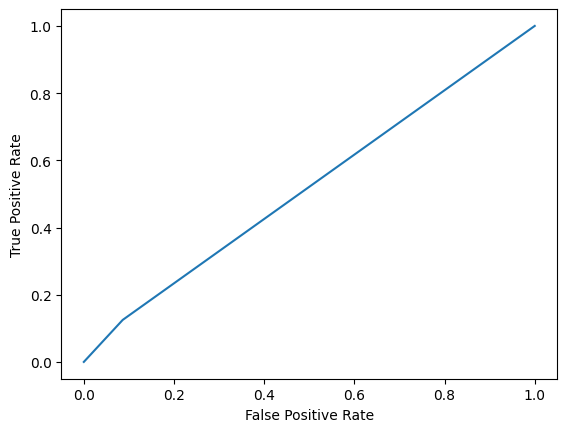

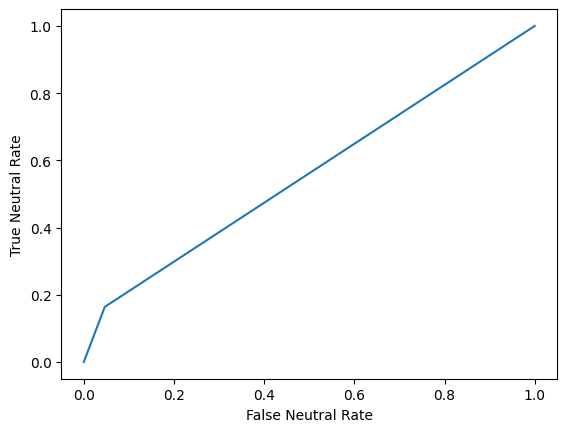

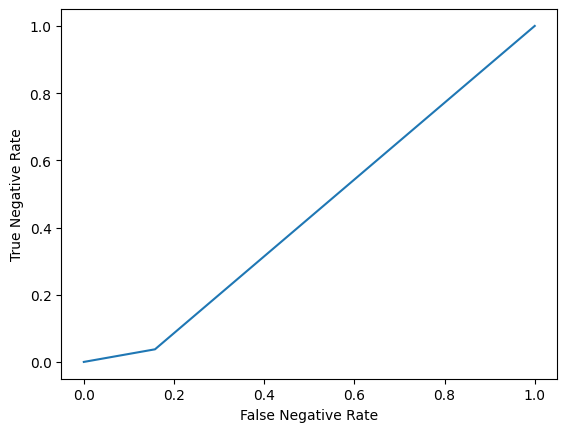

In [ ]:
create_roc_curve(y_pred_pl, y_test_pl)

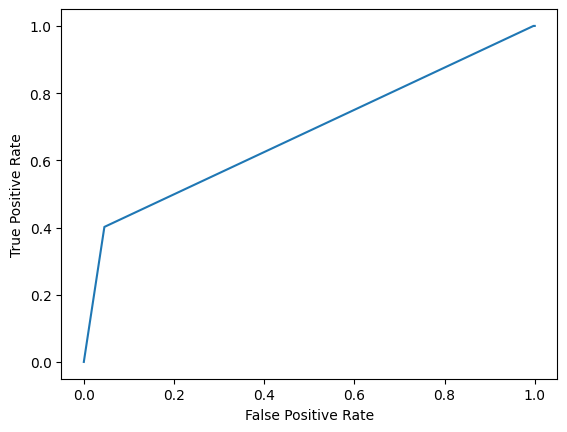

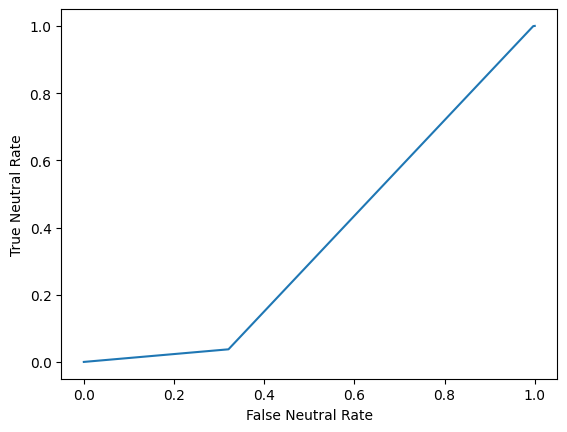

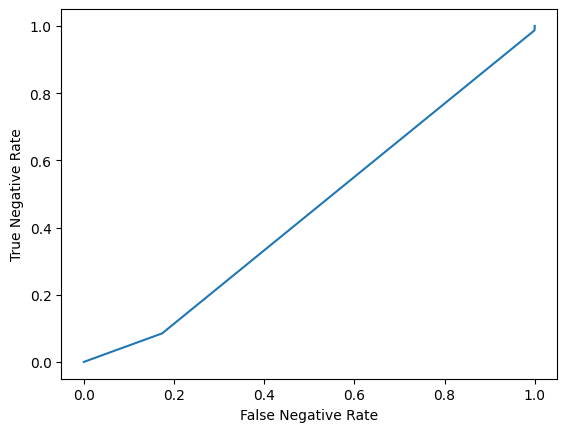

In [ ]:
create_roc_curve(y_pred_en, y_test_en)

Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_pl = SVC()
model_pl.fit(X_train_pl, y_train_pl)

SVC()

In [ ]:
model_en = SVC()
model_en.fit(X_train_en, y_train_en)

SVC()

In [ ]:
y_pred_pl = model_pl.predict(X_test_pl)

confusion_matrix(y_test_pl, y_pred_pl)

array([[1029,   89,    1],
       [ 427,  273,    2],
       [  73,   44,   11]])

In [ ]:
y_pred_en = model_en.predict(X_test_en)

confusion_matrix(y_test_en, y_pred_en)

array([[ 126,  151,   29],
       [  34, 1343,  115],
       [  14,  271,  606]])

In [ ]:
print(classification_report(y_test_pl, y_pred_pl))

              precision    recall  f1-score   support

          -1       0.67      0.92      0.78      1119
           0       0.67      0.39      0.49       702
           1       0.79      0.09      0.15       128

    accuracy                           0.67      1949
   macro avg       0.71      0.46      0.47      1949
weighted avg       0.68      0.67      0.63      1949



In [ ]:
print(classification_report(y_test_en, y_pred_en))

              precision    recall  f1-score   support

          -1       0.72      0.41      0.53       306
           0       0.76      0.90      0.82      1492
           1       0.81      0.68      0.74       891

    accuracy                           0.77      2689
   macro avg       0.76      0.66      0.70      2689
weighted avg       0.77      0.77      0.76      2689



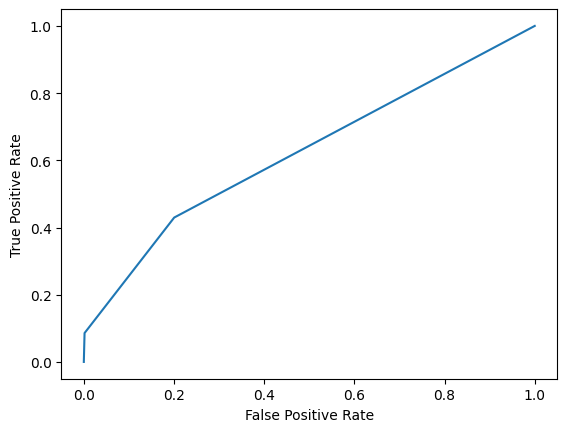

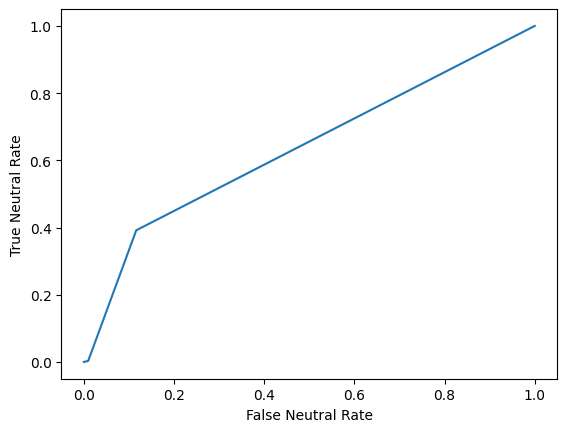

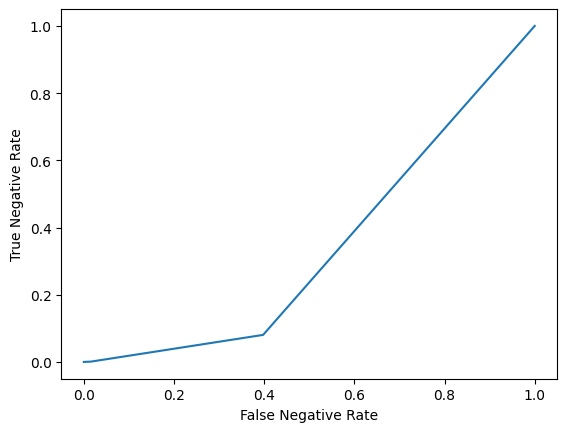

In [ ]:
create_roc_curve(y_pred_pl, y_test_pl)

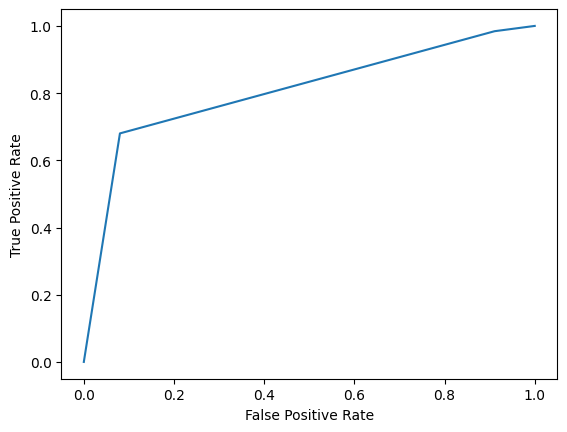

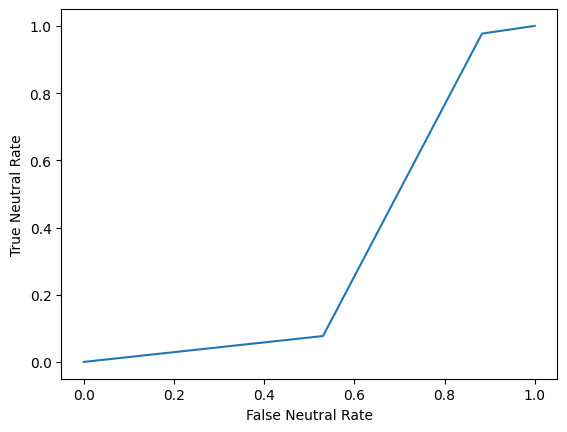

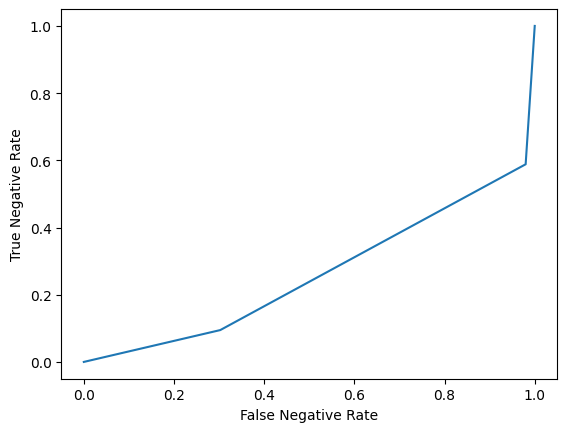

In [ ]:
create_roc_curve(y_pred_en, y_test_en)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_pl = LogisticRegression(solver='liblinear', random_state=0)
model_pl.fit(X_train_pl, y_train_pl)

confusion_matrix(y_test_pl, y_pred_pl)

array([[1029,   89,    1],
       [ 427,  273,    2],
       [  73,   44,   11]])

In [ ]:
model_en = LogisticRegression(solver='liblinear', random_state=0)
model_en.fit(X_train_en, y_train_en)

confusion_matrix(y_test_en, y_pred_en)

array([[ 126,  151,   29],
       [  34, 1343,  115],
       [  14,  271,  606]])

In [ ]:
y_pred_pl = model_pl.predict(X_test_pl)

confusion_matrix(y_test_pl, y_pred_pl)

array([[1034,   84,    1],
       [ 422,  279,    1],
       [  70,   51,    7]])

In [ ]:
y_pred_en = model_en.predict(X_test_en)

confusion_matrix(y_test_en, y_pred_en)

array([[ 108,  157,   41],
       [  40, 1337,  115],
       [  14,  280,  597]])

In [ ]:
print(classification_report(y_test_pl, y_pred_pl))

              precision    recall  f1-score   support

          -1       0.68      0.92      0.78      1119
           0       0.67      0.40      0.50       702
           1       0.78      0.05      0.10       128

    accuracy                           0.68      1949
   macro avg       0.71      0.46      0.46      1949
weighted avg       0.68      0.68      0.64      1949



In [ ]:
print(classification_report(y_test_en, y_pred_en))

              precision    recall  f1-score   support

          -1       0.67      0.35      0.46       306
           0       0.75      0.90      0.82      1492
           1       0.79      0.67      0.73       891

    accuracy                           0.76      2689
   macro avg       0.74      0.64      0.67      2689
weighted avg       0.76      0.76      0.75      2689



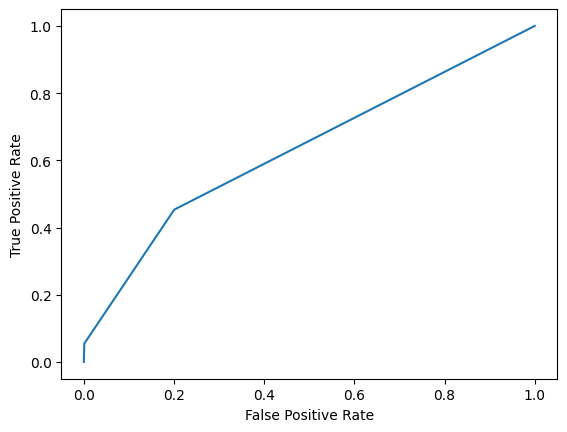

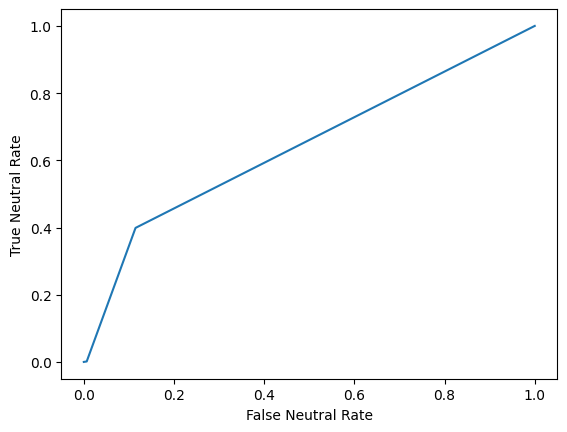

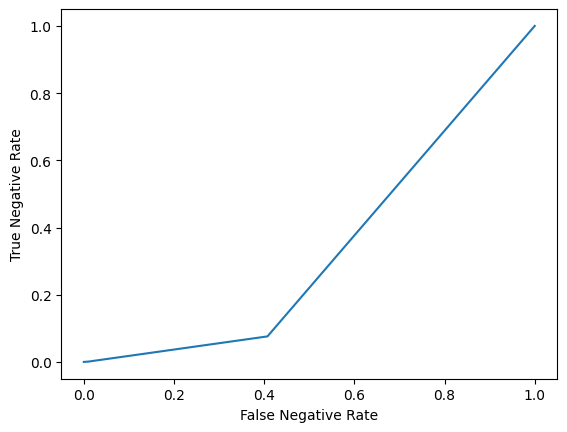

In [ ]:
create_roc_curve(y_pred_pl, y_test_pl)

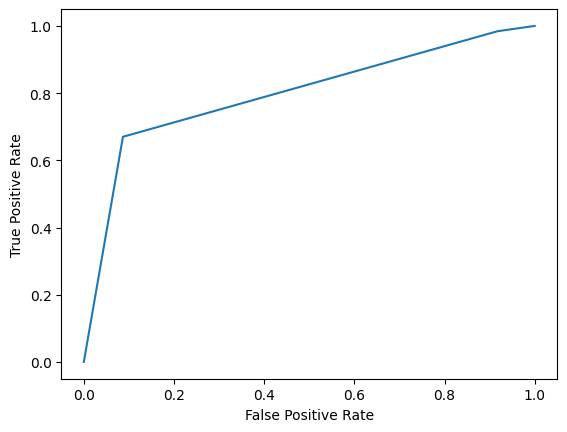

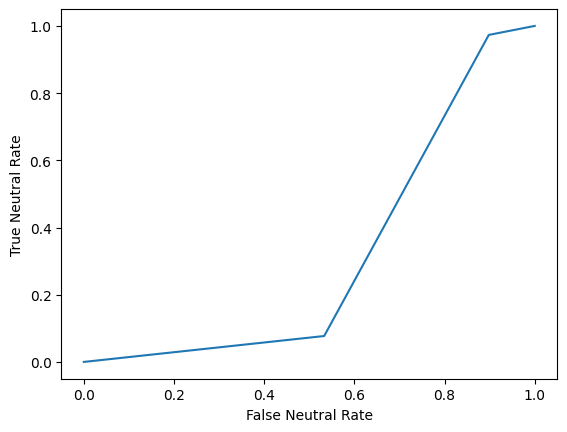

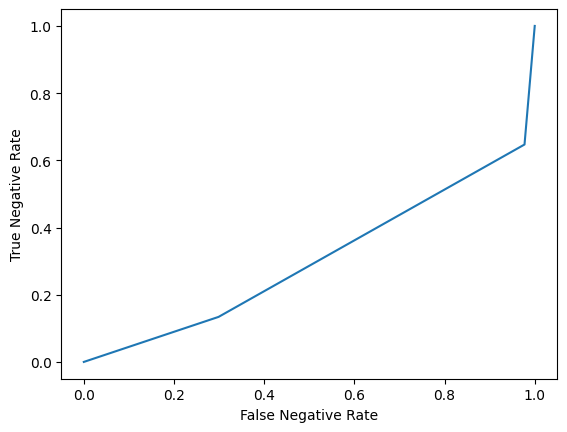

In [ ]:
create_roc_curve(y_pred_en, y_test_en)

#BERT


In [ ]:
!pip install transformers==4.26.1
!pip install -U datasets
!pip install plot_keras_history -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.8 MB/s eta 0:00

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoTokenizer, BertModel, BertTokenizerFast
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, RobertaForSequenceClassification
import pandas as pd
from datasets import Dataset
from datasets import load_metric
import numpy as np
import torch
from tensorflow.keras.callbacks import EarlyStopping
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
from datasets import Dataset

In [ ]:
file_cleaned_pl = data_pl.drop(labels=['sentiment'], axis=1).reset_index(drop=True).rename(columns={'tweet':'text', 'target':'labels'})
file_cleaned_pl.labels.replace([1, 0, -1], [2, 1, 0], inplace=True)
file_cleaned_pl

,text,labels
0,od czas wpuszczec ukrainski zboze polski rynek...,1
1,za nikt tyle odebrac ukradnie pis wolec miec o...,0
2,minister podpisac dokument przyspieszyc transf...,1
3,pozytywny przekaz majstrowac komisarza pis wie...,1
4,platforma media atakowac klamstwo manipulacj d...,1
...,...,...
19485,mow siebie za dlugo obserwowac scena polityczn...,0
19486,dla kto eldorado emeryt rzadzacy dzieki progra...,1
19487,przestan dziewcze belkotac ! bzdura gaworzyc !...,0
19488,czyli wolec pan pis likwidacja panstwo ?,0


In [ ]:
file_cleaned_en = data_en.drop(labels=['sentiment'], axis=1).reset_index(drop=True).rename(columns={'tweet':'text', 'target':'labels'})
file_cleaned_en.labels.replace([1, 0, -1], [2, 1, 0], inplace=True)
file_cleaned_en

,text,labels
0,united by music slogan year s esc we re look f...,2
1,junior eurovision 2023 hold nice november 26 !...,2
2,slovenia 5/10 same song like year europe vote ...,1
3,dear be wrong with you ? ? ? do not diligence ...,0
4,poland 7/10 still disqualification ? so sick h...,1
...,...,...
26879,you right slander germany year idc what be opi...,1
26880,so addition know 7 boy / male band eurovision2...,2
26881,be bang win eurovision 2023 ?,1
26882,this drill growl return eurovision !,1


In [ ]:
dataset_pl = Dataset.from_pandas(file_cleaned_pl)
dataset_pl = dataset_pl.train_test_split(0.1)

In [ ]:
dataset_en = Dataset.from_pandas(file_cleaned_en)
dataset_en = dataset_en.train_test_split(0.1)

In [ ]:
print(dataset_en)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 24195
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2689
    })
})


In [ ]:
model_checkpoint_distilbert = 'distilbert-base-uncased'
batch_size = 64

In [ ]:
model_checkpoint_roberta = 'roberta-base'
batch_size = 64

In [ ]:
tokenizer_roberta = AutoTokenizer.from_pretrained(model_checkpoint_roberta, use_fast=True)
tokenizer_distilbert = AutoTokenizer.from_pretrained(model_checkpoint_distilbert, use_fast=True)

In [ ]:
def process_roberta(x):
  return tokenizer_roberta(x['text'])

def process_distilbert(x):
  return tokenizer_distilbert(x['text'])

train_ds_roberta_pl = dataset_pl['train'].map(process_roberta)
test_ds_roberta_pl = dataset_pl['test'].map(process_roberta)

train_ds_distilbert_pl = dataset_pl['train'].map(process_distilbert)
test_ds_distilbert_pl = dataset_pl['test'].map(process_distilbert)

Map:   0%|          | 0/17541 [00:00<?, ? examples/s]

Map:   0%|          | 0/1949 [00:00<?, ? examples/s]

Map:   0%|          | 0/17541 [00:00<?, ? examples/s]

Map:   0%|          | 0/1949 [00:00<?, ? examples/s]

In [ ]:
train_ds_roberta_en = dataset_en['train'].map(process_roberta)
test_ds_roberta_en = dataset_en['test'].map(process_roberta)

train_ds_distilbert_en = dataset_en['train'].map(process_distilbert)
test_ds_distilbert_en = dataset_en['test'].map(process_distilbert)

Map:   0%|          | 0/24195 [00:00<?, ? examples/s]

Map:   0%|          | 0/2689 [00:00<?, ? examples/s]

Map:   0%|          | 0/24195 [00:00<?, ? examples/s]

Map:   0%|          | 0/2689 [00:00<?, ? examples/s]

In [ ]:
num_labels = 3
model_distilbert = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_distilbert, num_labels=num_labels)
model_roberta = RobertaForSequenceClassification.from_pretrained(model_checkpoint_roberta, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
args_distilbert = TrainingArguments(
    f'{model_checkpoint_distilbert}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.02,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
    
)

args_roberta = TrainingArguments(
    f'{model_checkpoint_roberta}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.02,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
    
)

In [ ]:
metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

<ipython-input-41-a6bf47ba013e>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'sst2')


In [ ]:
train_ds_distilbert_en

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 24195
})

In [ ]:
dataset_pl = dataset_pl.with_format("torch")
dataset_en = dataset_en.with_format("torch")

In [ ]:
es = EarlyStopping(monitor='Accuracy', mode='max', patience=5, restore_best_weights=True)

In [ ]:
trainer_distilbert_pl = Trainer(
    model_distilbert,
    args_distilbert,
    train_dataset=train_ds_distilbert_pl,
    eval_dataset=test_ds_distilbert_pl,
    tokenizer=tokenizer_distilbert,
    compute_metrics=compute_metrics,
)

trainer_distilbert_en = Trainer(
    model_distilbert,
    args_distilbert,
    train_dataset=train_ds_distilbert_en,
    eval_dataset=test_ds_distilbert_en,
    tokenizer=tokenizer_distilbert,
    compute_metrics=compute_metrics,
)

trainer_roberta_pl = Trainer(
    model_roberta,
    args_roberta,
    train_dataset=train_ds_roberta_pl,
    eval_dataset=test_ds_roberta_pl,
    tokenizer=tokenizer_roberta,
    compute_metrics=compute_metrics,
)

trainer_roberta_en = Trainer(
    model_roberta,
    args_roberta,
    train_dataset=train_ds_roberta_en,
    eval_dataset=test_ds_roberta_en,
    tokenizer=tokenizer_roberta,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_roberta_pl.evaluate([train_ds_roberta_pl[0]])

***** Running Evaluation *****
  Num examples = 1
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.0653018951416016,
 'eval_accuracy': 1.0,
 'eval_runtime': 2.7643,
 'eval_samples_per_second': 0.362,
 'eval_steps_per_second': 0.362}

In [ ]:
trainer_roberta_en.evaluate([train_ds_roberta_en[0]])

***** Running Evaluation *****
  Num examples = 1
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 1.1619162559509277,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.0393,
 'eval_samples_per_second': 25.462,
 'eval_steps_per_second': 25.462}

In [ ]:
trainer_distilbert_pl.evaluate([train_ds_distilbert_pl[0]])

***** Running Evaluation *****
  Num examples = 1
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.0629364252090454,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.0437,
 'eval_samples_per_second': 22.907,
 'eval_steps_per_second': 22.907}

In [ ]:
trainer_distilbert_en.evaluate([train_ds_distilbert_en[0]])

***** Running Evaluation *****
  Num examples = 1
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 1.0728580951690674,
 'eval_accuracy': 1.0,
 'eval_runtime': 0.038,
 'eval_samples_per_second': 26.287,
 'eval_steps_per_second': 26.287}

In [ ]:
trainer_roberta_pl.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17541
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1375
  Number of trainable parameters = 124647939


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.828165,0.597742
2,0.799900,0.738147,0.653669
3,0.799900,0.735152,0.659312
4,0.688800,0.744443,0.669574
5,0.688800,0.749889,0.667009


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1949
  Batch size = 64


Saving model checkpoint to roberta-base_sentiment_analysis/checkpoint-275
Configuration saved in roberta-base_sentiment_analysis/checkpoint-275/config.json
Model weights saved in roberta-base_sentiment_analysis/checkpoint-275/pytorch_model.bin
tokenizer config file saved in roberta-base_sentiment_analysis/checkpoint-275/tokenizer_config.json
Special tokens file saved in roberta-base_sentiment_analysis/checkpoint-275/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1949
  Batch size = 64
Saving model checkpoint to roberta-base_sentiment_analysis/checkpoint-550
Configuration saved in roberta-base_sentiment_analysis/checkpoint-550/config.json
Model weights saved in roberta-base_sentiment_analysis/checkpoint

TrainOutput(global_step=1375, training_loss=0.711301435990767, metrics={'train_runtime': 1480.6912, 'train_samples_per_second': 59.232, 'train_steps_per_second': 0.929, 'total_flos': 4711649055264396.0, 'train_loss': 0.711301435990767, 'epoch': 5.0})

In [ ]:
trainer_roberta_en.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24195
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1895
  Number of trainable parameters = 124647939


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.357832,0.856824
2,0.432200,0.339538,0.860543
3,0.268400,0.322009,0.876906
4,0.197900,0.333117,0.876162
5,0.197900,0.373354,0.873931


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2689
  Batch size = 64


Saving model checkpoint to roberta-base_sentiment_analysis/checkpoint-379
Configuration saved in roberta-base_sentiment_analysis/checkpoint-379/config.json
Model weights saved in roberta-base_sentiment_analysis/checkpoint-379/pytorch_model.bin
tokenizer config file saved in roberta-base_sentiment_analysis/checkpoint-379/tokenizer_config.json
Special tokens file saved in roberta-base_sentiment_analysis/checkpoint-379/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2689
  Batch size = 64
Saving model checkpoint to roberta-base_sentiment_analysis/checkpoint-758
Configuration saved in roberta-base_sentiment_analysis/checkpoint-758/config.json
Model weights saved in roberta-base_sentiment_analysis/checkpoint

TrainOutput(global_step=1895, training_loss=0.26667400953952114, metrics={'train_runtime': 1198.6784, 'train_samples_per_second': 100.924, 'train_steps_per_second': 1.581, 'total_flos': 3654545676923484.0, 'train_loss': 0.26667400953952114, 'epoch': 5.0})

In [ ]:
trainer_distilbert_pl.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17541
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1375
  Number of trainable parameters = 66955779


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.775107,0.632119
2,0.767500,0.708710,0.671113
3,0.767500,0.689650,0.681888
4,0.627800,0.696100,0.689584
5,0.627800,0.699876,0.693689


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1949
  Batch size = 64


Saving model checkpoint to distilbert-base-uncased_sentiment_analysis/checkpoint-275
Configuration saved in distilbert-base-uncased_sentiment_analysis/checkpoint-275/config.json
Model weights saved in distilbert-base-uncased_sentiment_analysis/checkpoint-275/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased_sentiment_analysis/checkpoint-275/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased_sentiment_analysis/checkpoint-275/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1949
  Batch size = 64
Saving model checkpoint to distilbert-base-uncased_sentiment_analysis/checkpoint-550
Configuration saved in distilbert-base-uncased_sentiment_analysis/checkpoin

TrainOutput(global_step=1375, training_loss=0.6572872314453125, metrics={'train_runtime': 724.0516, 'train_samples_per_second': 121.131, 'train_steps_per_second': 1.899, 'total_flos': 2255385132174276.0, 'train_loss': 0.6572872314453125, 'epoch': 5.0})

In [ ]:
trainer_distilbert_en.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24195
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1895
  Number of trainable parameters = 66955779


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.363365,0.853105
2,0.440800,0.322049,0.867609
3,0.271700,0.338504,0.872071
4,0.186400,0.371337,0.870212
5,0.186400,0.389060,0.870212


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2689
  Batch size = 64


Saving model checkpoint to distilbert-base-uncased_sentiment_analysis/checkpoint-379
Configuration saved in distilbert-base-uncased_sentiment_analysis/checkpoint-379/config.json
Model weights saved in distilbert-base-uncased_sentiment_analysis/checkpoint-379/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased_sentiment_analysis/checkpoint-379/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased_sentiment_analysis/checkpoint-379/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2689
  Batch size = 64
Saving model checkpoint to distilbert-base-uncased_sentiment_analysis/checkpoint-758
Configuration saved in distilbert-base-uncased_sentiment_analysis/checkpoin

TrainOutput(global_step=1895, training_loss=0.2653818658914289, metrics={'train_runtime': 565.4519, 'train_samples_per_second': 213.944, 'train_steps_per_second': 3.351, 'total_flos': 1693204940978586.0, 'train_loss': 0.2653818658914289, 'epoch': 5.0})

In [ ]:
trainer_roberta_pl.save_model('trainer_roberta_pl.model')
trainer_roberta_en.save_model('trainer_roberta_en.model')
trainer_distilbert_pl.save_model('trainer_distilbert_pl.model')
trainer_distilbert_en.save_model('trainer_distilbert_en.model')

In [ ]:
trainer_roberta_pl.model
trainer_roberta_en.model
trainer_distilbert_pl.model
trainer_distilbert_en.model

In [ ]:
text_to_test = "PIS"  

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

inputs = tokenizer(text_to_test, return_tensors='pt')
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  output = model_roberta(input_ids=input_ids, attention_mask=attention_mask)
  logits = output.logits
  predictions = torch.argmax(logits, dim=-1)

predictions.item()
print('Roberta:')
if predictions.item() == 0:
  print('This text is negative')
elif predictions.item() == 1 :
  print('This text is neutral')
else :
  print('This text is positive')

with torch.no_grad():
  output = model_distilbert(input_ids=input_ids, attention_mask=attention_mask)
  logits = output.logits
  predictions = torch.argmax(logits, dim=-1)

predictions.item()

print('Distilbert')
if predictions.item() == 0:
  print('This text is negative')
elif predictions.item() == 1 :
  print('This text is neutral')
else :
  print('This text is positive')

#LSTM - Język Polski



In [ ]:
data_pl

,tweet,sentiment,target
0,od czas wpuszczec ukrainski zboze polski rynek...,neutral,0
1,za nikt tyle odebrac ukradnie pis wolec miec o...,negative,-1
2,minister podpisac dokument przyspieszyc transf...,neutral,0
3,pozytywny przekaz majstrowac komisarza pis wie...,neutral,0
4,platforma media atakowac klamstwo manipulacj d...,neutral,0
...,...,...,...
19485,mow siebie za dlugo obserwowac scena polityczn...,negative,-1
19486,dla kto eldorado emeryt rzadzacy dzieki progra...,neutral,0
19487,przestan dziewcze belkotac ! bzdura gaworzyc !...,negative,-1
19488,czyli wolec pan pis likwidacja panstwo ?,negative,-1


In [ ]:
max_words = 5000
max_len = 200

tokenizer_lstm_pl = Tokenizer(num_words=max_words)

# przypasowanie do danych
tokenizer_lstm_pl.fit_on_texts(data_pl.tweet)
# tworzenie sekwencji ze stokanizowanego tekstu
sequences = tokenizer_lstm_pl.texts_to_sequences(data_pl.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  500    2  504]
 [   0    0    0 ...  501  464    3]
 [   0    0    0 ... 2968   88  788]
 ...
 [   0    0    0 ...    1  779   13]
 [   0    0    0 ...    1 1473   56]
 [   0    0    0 ... 4417 1100  640]]


In [ ]:
# tworzenie etykiet
labels = to_categorical(data_pl.target, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
model_lstm_pl = Sequential()
model_lstm_pl.add(layers.Embedding(max_words, 20))
model_lstm_pl.add(layers.LSTM(15, dropout=0.5))
model_lstm_pl.add(layers.Dense(3, activation='softmax'))

model_lstm_pl.compile(optimizer='rmsprop', 
               loss= 'categorical_crossentropy',
               metrics=['accuracy'])

history_lstm_pl = model_lstm_pl.fit(X_train,
                     y_train,
                     epochs=10,
                     validation_data=(X_test, y_test))

Epoch 1/10
757/757 [==============================] - 25s 30ms/step - loss: 0.8481 - accuracy: 0.5948 - val_loss: 0.7137 - val_accuracy: 0.6865
Epoch 2/10
757/757 [==============================] - 14s 19ms/step - loss: 0.6602 - accuracy: 0.7230 - val_loss: 0.6213 - val_accuracy: 0.7412
Epoch 3/10
757/757 [==============================] - 18s 23ms/step - loss: 0.5944 - accuracy: 0.7553 - val_loss: 0.6259 - val_accuracy: 0.7482
Epoch 4/10
757/757 [==============================] - 13s 17ms/step - loss: 0.5581 - accuracy: 0.7739 - val_loss: 0.5928 - val_accuracy: 0.7542
Epoch 5/10
757/757 [==============================] - 15s 20ms/step - loss: 0.5363 - accuracy: 0.7838 - val_loss: 0.5922 - val_accuracy: 0.7534
Epoch 6/10
757/757 [==============================] - 14s 18ms/step - loss: 0.5119 - accuracy: 0.7934 - val_loss: 0.5621 - val_accuracy: 0.7683
Epoch 7/10
757/757 [==============================] - 16s 21ms/step - loss: 0.5023 - accuracy: 0.7980 - val_loss: 0.5665 - val_accuracy:

LSTM



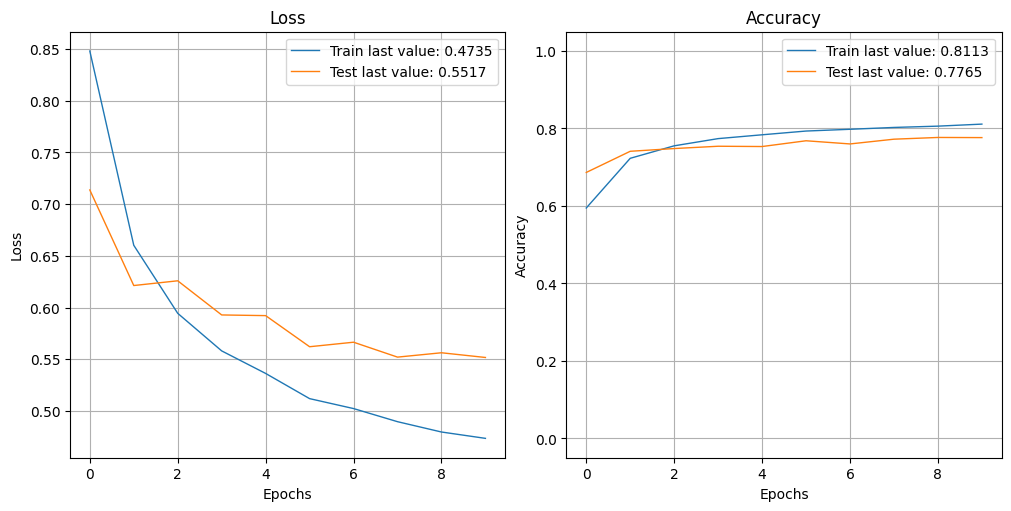

In [ ]:
print(r'LSTM')
print()
show_history(history_lstm_pl)
plot_history(history_lstm_pl)
plt.close()

# LSTM - Język Angielski


In [ ]:
max_words = 5000
max_len = 200

tokenizer_lstm_en = Tokenizer(num_words=max_words)

# przypasowanie do danych
tokenizer_lstm_en.fit_on_texts(data_en.tweet)
# tworzenie sekwencji ze stokanizowanego tekstu
sequences = tokenizer_lstm_en.texts_to_sequences(data_en.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  816  114  100]
 [   0    0    0 ... 2494    1 1272]
 [   0    0    0 ...    6    9    1]
 ...
 [   0    0    0 ...   24    1    7]
 [   0    0    0 ... 3751  467    1]
 [   0    0    0 ...  304   11    1]]


In [ ]:
# tworzenie etykiet
labels = to_categorical(data_en.target, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
model_lstm_en = Sequential()
model_lstm_en.add(layers.Embedding(max_words, 20))
model_lstm_en.add(layers.LSTM(15, dropout=0.5))
model_lstm_en.add(layers.Dense(3, activation='softmax'))

model_lstm_en.compile(optimizer='rmsprop', 
               loss= 'categorical_crossentropy',
               metrics=['accuracy'])

history_lstm_en = model_lstm_en.fit(X_train,
                     y_train,
                     epochs=10,
                     validation_data=(X_test, y_test))

Epoch 1/10
757/757 [==============================] - 27s 32ms/step - loss: 0.8369 - accuracy: 0.6171 - val_loss: 0.7448 - val_accuracy: 0.6750
Epoch 2/10
757/757 [==============================] - 8s 11ms/step - loss: 0.6782 - accuracy: 0.7165 - val_loss: 0.6429 - val_accuracy: 0.7255
Epoch 3/10
757/757 [==============================] - 12s 16ms/step - loss: 0.6024 - accuracy: 0.7561 - val_loss: 0.6001 - val_accuracy: 0.7482
Epoch 4/10
757/757 [==============================] - 8s 10ms/step - loss: 0.5607 - accuracy: 0.7708 - val_loss: 0.5765 - val_accuracy: 0.7639
Epoch 5/10
757/757 [==============================] - 8s 10ms/step - loss: 0.5404 - accuracy: 0.7790 - val_loss: 0.5630 - val_accuracy: 0.7687
Epoch 6/10
757/757 [==============================] - 8s 11ms/step - loss: 0.5210 - accuracy: 0.7905 - val_loss: 0.5591 - val_accuracy: 0.7661
Epoch 7/10
757/757 [==============================] - 7s 10ms/step - loss: 0.5046 - accuracy: 0.7953 - val_loss: 0.5547 - val_accuracy: 0.76

LSTM



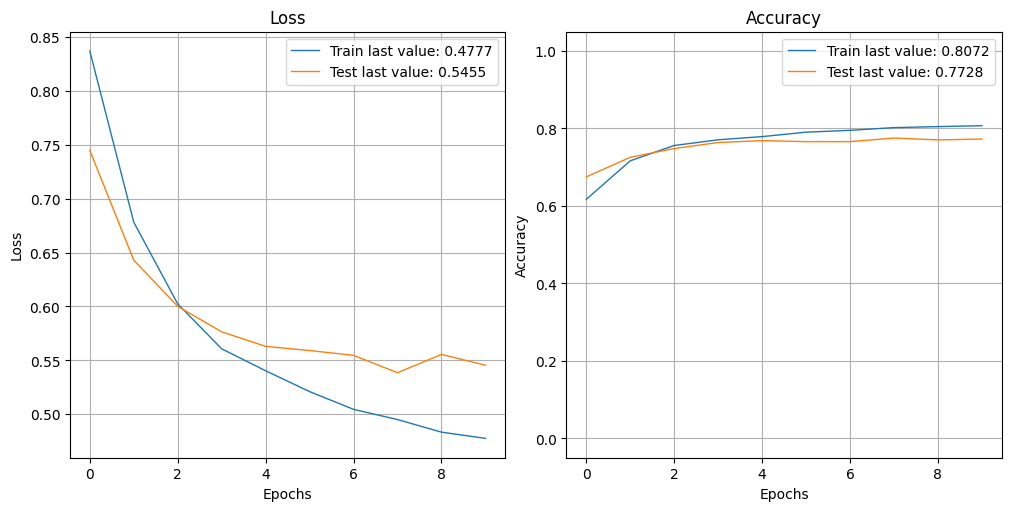

In [ ]:
print(r'LSTM')
print()
show_history(history_lstm_en)
plot_history(history_lstm_en)
plt.close()

#BLSTM - Język Polski


In [ ]:
max_words = 5000
max_len = 200

tokenizer_blstm_pl = Tokenizer(num_words=max_words)

# przypasowanie do danych
tokenizer_blstm_pl.fit_on_texts(data_pl.tweet)
# tworzenie sekwencji ze stokanizowanego tekstu
sequences = tokenizer_blstm_pl.texts_to_sequences(data_pl.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  500    2  504]
 [   0    0    0 ...  501  464    3]
 [   0    0    0 ... 2968   88  788]
 ...
 [   0    0    0 ...    1  779   13]
 [   0    0    0 ...    1 1473   56]
 [   0    0    0 ... 4417 1100  640]]


In [ ]:
# tworzenie etykiet
labels = to_categorical(data_pl.target, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
model_blstm_pl = Sequential()

model_blstm_pl.add(layers.Embedding(max_words, 40))
model_blstm_pl.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
model_blstm_pl.add(layers.Dense(3, activation='softmax'))

model_blstm_pl.compile(optimizer='rmsprop', 
               loss= 'categorical_crossentropy',
               metrics=['accuracy'])

history_blstm_pl = model_blstm_pl.fit(X_train,
                     y_train,
                     epochs=10,
                     validation_data=(X_test, y_test))

Epoch 1/10
549/549 [==============================] - 53s 78ms/step - loss: 0.8236 - accuracy: 0.5911 - val_loss: 0.7528 - val_accuracy: 0.6660
Epoch 2/10
549/549 [==============================] - 22s 39ms/step - loss: 0.7312 - accuracy: 0.6628 - val_loss: 0.7047 - val_accuracy: 0.6911
Epoch 3/10
549/549 [==============================] - 19s 35ms/step - loss: 0.6856 - accuracy: 0.6874 - val_loss: 0.6927 - val_accuracy: 0.6809
Epoch 4/10
549/549 [==============================] - 22s 41ms/step - loss: 0.6570 - accuracy: 0.7054 - val_loss: 0.6848 - val_accuracy: 0.6814
Epoch 5/10
549/549 [==============================] - 19s 34ms/step - loss: 0.6379 - accuracy: 0.7177 - val_loss: 0.7220 - val_accuracy: 0.6609
Epoch 6/10
549/549 [==============================] - 13s 24ms/step - loss: 0.6213 - accuracy: 0.7246 - val_loss: 0.6974 - val_accuracy: 0.6911
Epoch 7/10
549/549 [==============================] - 16s 30ms/step - loss: 0.6079 - accuracy: 0.7368 - val_loss: 0.6929 - val_accuracy:

BLSTM



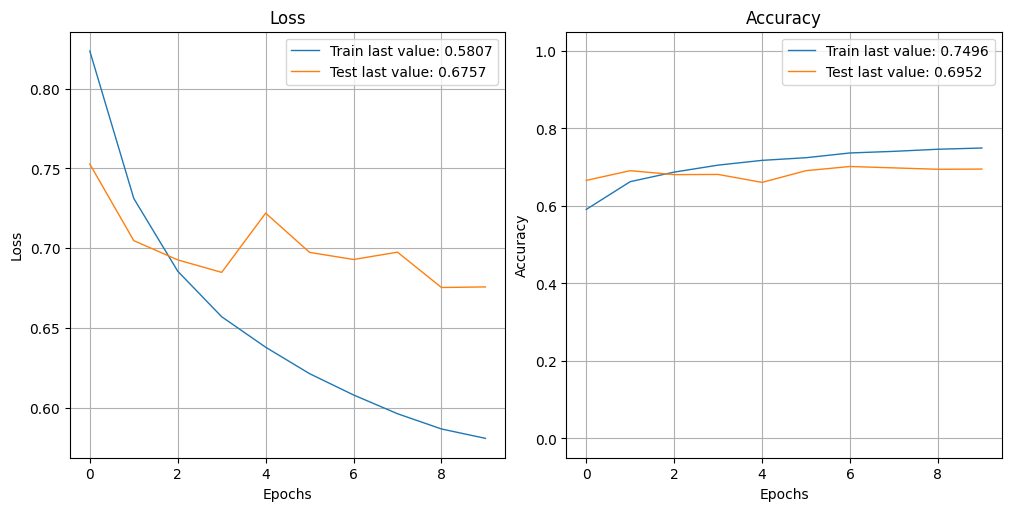

In [ ]:
print(r'BLSTM')
print()
show_history(history_blstm_pl)
plot_history(history_blstm_pl)
plt.close()

#BLSTM - Język Angielski

In [ ]:
max_words = 5000
max_len = 200

tokenizer_blstm_en = Tokenizer(num_words=max_words)

# przypasowanie do danych
tokenizer_blstm_en.fit_on_texts(data_en.tweet)
# tworzenie sekwencji ze stokanizowanego tekstu
sequences = tokenizer_blstm_en.texts_to_sequences(data_en.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  816  114  100]
 [   0    0    0 ... 2494    1 1272]
 [   0    0    0 ...    6    9    1]
 ...
 [   0    0    0 ...   24    1    7]
 [   0    0    0 ... 3751  467    1]
 [   0    0    0 ...  304   11    1]]


In [ ]:
# tworzenie etykiet
labels = to_categorical(data_en.target, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
model_blstm_en = Sequential()

model_blstm_en.add(layers.Embedding(max_words, 40))
model_blstm_en.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
model_blstm_en.add(layers.Dense(3, activation='softmax'))

model_blstm_en.compile(optimizer='rmsprop', 
               loss= 'categorical_crossentropy',
               metrics=['accuracy'])

history_blstm_en = model_blstm_en.fit(X_train,
                     y_train,
                     epochs=10,
                     validation_data=(X_test, y_test))

Epoch 1/10
757/757 [==============================] - 33s 38ms/step - loss: 0.8194 - accuracy: 0.6267 - val_loss: 0.7264 - val_accuracy: 0.6854
Epoch 2/10
757/757 [==============================] - 15s 20ms/step - loss: 0.6467 - accuracy: 0.7310 - val_loss: 0.6280 - val_accuracy: 0.7334
Epoch 3/10
757/757 [==============================] - 13s 18ms/step - loss: 0.5889 - accuracy: 0.7580 - val_loss: 0.6098 - val_accuracy: 0.7475
Epoch 4/10
757/757 [==============================] - 13s 17ms/step - loss: 0.5530 - accuracy: 0.7757 - val_loss: 0.5697 - val_accuracy: 0.7657
Epoch 5/10
757/757 [==============================] - 14s 18ms/step - loss: 0.5260 - accuracy: 0.7866 - val_loss: 0.5753 - val_accuracy: 0.7635
Epoch 6/10
757/757 [==============================] - 14s 18ms/step - loss: 0.5091 - accuracy: 0.7951 - val_loss: 0.5712 - val_accuracy: 0.7575
Epoch 7/10
757/757 [==============================] - 13s 17ms/step - loss: 0.4947 - accuracy: 0.8002 - val_loss: 0.5651 - val_accuracy:

BLSTM



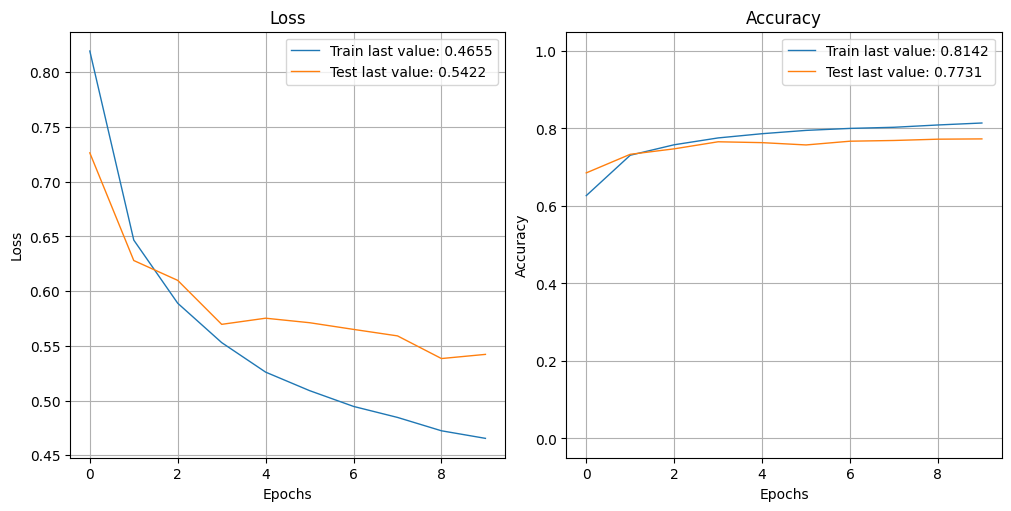

In [ ]:
print(r'BLSTM')
print()
show_history(history_blstm_en)
plot_history(history_blstm_en)
plt.close()

#Sieć Splotowa (CNN) - Język Polski

In [ ]:
max_words = 5000
max_len = 200

tokenizer_cnn_pl = Tokenizer(num_words=max_words)

# przypasowanie do danych
tokenizer_cnn_pl.fit_on_texts(data_pl.tweet)
# tworzenie sekwencji ze stokanizowanego tekstu
sequences = tokenizer_cnn_pl.texts_to_sequences(data_pl.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  500    2  504]
 [   0    0    0 ...  501  464    3]
 [   0    0    0 ... 2968   88  788]
 ...
 [   0    0    0 ...    1  779   13]
 [   0    0    0 ...    1 1473   56]
 [   0    0    0 ... 4417 1100  640]]


In [ ]:
# tworzenie etykiet
labels = to_categorical(data_pl.target, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
model_cnn_pl = Sequential()

model_cnn_pl.add(layers.Embedding(max_words, 40, input_length=max_len))
model_cnn_pl.add(layers.Conv1D(20, 6, activation='relu'))
model_cnn_pl.add(layers.MaxPooling1D(5))
model_cnn_pl.add(layers.Conv1D(20, 6, activation='relu'))
model_cnn_pl.add(layers.GlobalMaxPooling1D())
model_cnn_pl.add(layers.Dense(3, activation='softmax'))

model_cnn_pl.compile(optimizer='rmsprop', 
               loss= 'categorical_crossentropy',
               metrics=['accuracy'])

history_cnn_pl = model_cnn_pl.fit(X_train,
                     y_train,
                     epochs=10,
                     validation_data=(X_test, y_test))

Epoch 1/10
549/549 [==============================] - 28s 36ms/step - loss: 0.8289 - accuracy: 0.5869 - val_loss: 0.7592 - val_accuracy: 0.6588
Epoch 2/10
549/549 [==============================] - 5s 8ms/step - loss: 0.7039 - accuracy: 0.6830 - val_loss: 0.7091 - val_accuracy: 0.6870
Epoch 3/10
549/549 [==============================] - 6s 10ms/step - loss: 0.6293 - accuracy: 0.7293 - val_loss: 0.6974 - val_accuracy: 0.6901
Epoch 4/10
549/549 [==============================] - 4s 7ms/step - loss: 0.5603 - accuracy: 0.7653 - val_loss: 0.7169 - val_accuracy: 0.6665
Epoch 5/10
549/549 [==============================] - 3s 6ms/step - loss: 0.4776 - accuracy: 0.8018 - val_loss: 0.7408 - val_accuracy: 0.6824
Epoch 6/10
549/549 [==============================] - 4s 7ms/step - loss: 0.3926 - accuracy: 0.8440 - val_loss: 0.7880 - val_accuracy: 0.6896
Epoch 7/10
549/549 [==============================] - 4s 7ms/step - loss: 0.3168 - accuracy: 0.8790 - val_loss: 0.8332 - val_accuracy: 0.6650
Epo

Sieć spolotwa



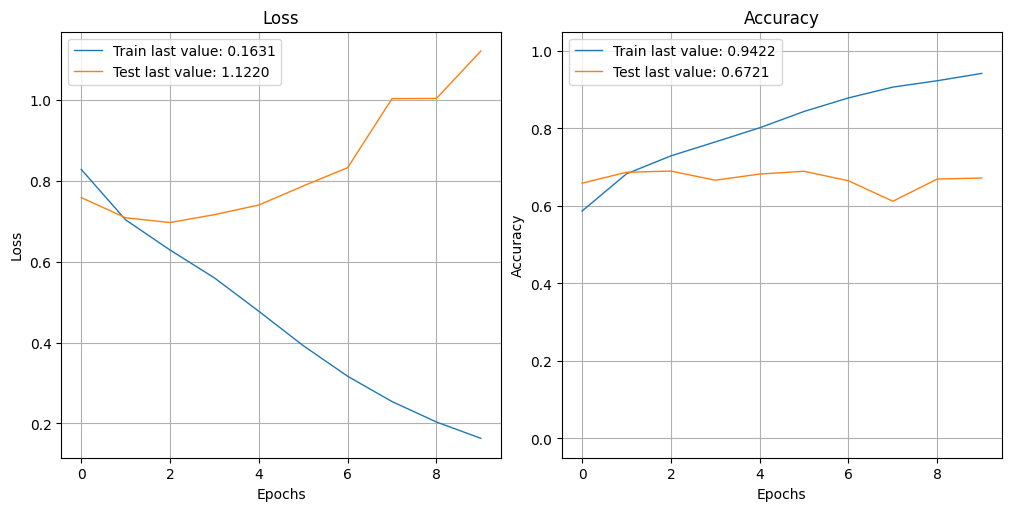

In [ ]:
print(r'Sieć spolotwa')
print()
show_history(history_cnn_pl)
plot_history(history_cnn_pl)
plt.close()

#Sieć Splotowa (CNN) - Język Angielski

In [ ]:
max_words = 5000
max_len = 200

tokenizer_cnn_en = Tokenizer(num_words=max_words)

# przypasowanie do danych
tokenizer_cnn_en.fit_on_texts(data_en.tweet)
# tworzenie sekwencji ze stokanizowanego tekstu
sequences = tokenizer_cnn_en.texts_to_sequences(data_en.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  816  114  100]
 [   0    0    0 ... 2494    1 1272]
 [   0    0    0 ...    6    9    1]
 ...
 [   0    0    0 ...   24    1    7]
 [   0    0    0 ... 3751  467    1]
 [   0    0    0 ...  304   11    1]]


In [ ]:
# tworzenie etykiet
labels = to_categorical(data_en.target, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

In [ ]:
model_cnn_en = Sequential()

model_cnn_en.add(layers.Embedding(max_words, 40, input_length=max_len))
model_cnn_en.add(layers.Conv1D(20, 6, activation='relu'))
model_cnn_en.add(layers.MaxPooling1D(5))
model_cnn_en.add(layers.Conv1D(20, 6, activation='relu'))
model_cnn_en.add(layers.GlobalMaxPooling1D())
model_cnn_en.add(layers.Dense(3, activation='softmax'))

model_cnn_en.compile(optimizer='rmsprop', 
               loss= 'categorical_crossentropy',
               metrics=['accuracy'])

history_cnn_en = model_cnn_en.fit(X_train,
                     y_train,
                     epochs=10,
                     validation_data=(X_test, y_test))

Epoch 1/10
757/757 [==============================] - 20s 24ms/step - loss: 0.8201 - accuracy: 0.6317 - val_loss: 0.6795 - val_accuracy: 0.7259
Epoch 2/10
757/757 [==============================] - 5s 7ms/step - loss: 0.5797 - accuracy: 0.7633 - val_loss: 0.5773 - val_accuracy: 0.7531
Epoch 3/10
757/757 [==============================] - 6s 8ms/step - loss: 0.4839 - accuracy: 0.8062 - val_loss: 0.5491 - val_accuracy: 0.7631
Epoch 4/10
757/757 [==============================] - 5s 6ms/step - loss: 0.4242 - accuracy: 0.8322 - val_loss: 0.5501 - val_accuracy: 0.7720
Epoch 5/10
757/757 [==============================] - 4s 6ms/step - loss: 0.3711 - accuracy: 0.8568 - val_loss: 0.5380 - val_accuracy: 0.7743
Epoch 6/10
757/757 [==============================] - 6s 7ms/step - loss: 0.3226 - accuracy: 0.8780 - val_loss: 0.5657 - val_accuracy: 0.7750
Epoch 7/10
757/757 [==============================] - 4s 5ms/step - loss: 0.2727 - accuracy: 0.8992 - val_loss: 0.6447 - val_accuracy: 0.7709
Epoc

Sieć spolotwa



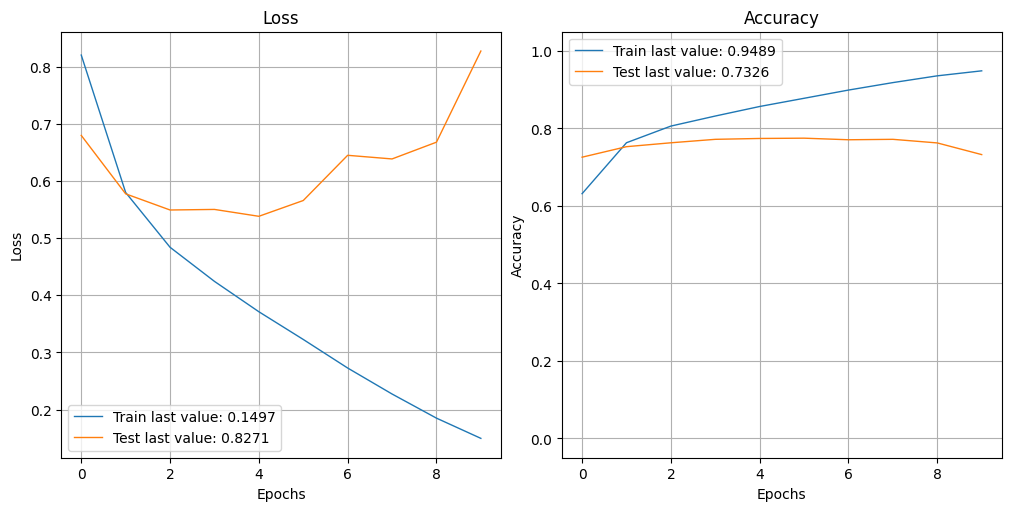

In [ ]:
print(r'Sieć spolotwa')
print()
show_history(history_cnn_en)
plot_history(history_cnn_en)
plt.close()

#Test LSTM, BLSTM, CNN - Język Polski


In [ ]:
predict(model_lstm_pl, ['Polska jest krajem w Europie'], tokenizer_lstm_pl)

1/1 - 1s - 942ms/epoch - 942ms/step
[0.787398   0.20223522 0.01036687]
['Polska jest krajem w Europie']
Predicted sentiment :  Negative


In [ ]:
predict(model_blstm_pl, ['Polska jest krajem w Europie'], tokenizer_blstm_pl)

1/1 - 1s - 1s/epoch - 1s/step
[0.4692752  0.32304034 0.2076844 ]
['Polska jest krajem w Europie']
Predicted sentiment :  Negative


In [ ]:
predict(model_cnn_pl, ['Polska jest krajem w Europie'], tokenizer_cnn_pl)

1/1 - 0s - 119ms/epoch - 119ms/step
[0.1726086  0.7779633  0.04942803]
['Polska jest krajem w Europie']
Predicted sentiment :  Neutral


#Test LSTM, BLSTM, CNN - Język Angielski

In [ ]:
predict(model_lstm_en, ['Poland is a country in Europe'], tokenizer_lstm_en)

1/1 - 0s - 21ms/epoch - 21ms/step
[0.94554377 0.04482278 0.00963346]
['Poland is a country in Europe']
Predicted sentiment :  Negative


In [ ]:
predict(model_blstm_en, ['Poland is a country in Europe'], tokenizer_blstm_en)

1/1 - 1s - 937ms/epoch - 937ms/step
[0.9474261  0.04326627 0.00930769]
['Poland is a country in Europe']
Predicted sentiment :  Negative


In [ ]:
predict(model_cnn_en, ['Poland is a country in Europe'], tokenizer_cnn_en)

1/1 - 0s - 111ms/epoch - 111ms/step
[0.7216613  0.25354633 0.02479238]
['Poland is a country in Europe']
Predicted sentiment :  Negative
